# How to manage conversation history

One of the most common use cases for persistence is to use it to keep track of conversation history. This is great - it makes it easy to continue conversations. As conversations get longer and longer, however, this conversation history can build up and take up more and more of the context window. This can often be undesirable as it leads to more expensive and longer calls to the LLM, and potentially ones that error. In order to prevent this from happening, you need to probably manage the conversation history.

Note: this guide focuses on how to do this in LangGraph, where you can fully customize how this is done. If you want a more off-the-shelf solution, you can look into functionality provided in LangChain:

- [How to filter messages](https://python.langchain.com/v0.2/docs/how_to/filter_messages/)
- [How to trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/)

## Setup

First, let's set up the packages we're going to want to use

In [1]:
# %%capture --no-stderr
# %pip install --quiet -U langgraph langchain_anthropic

Next, we need to set API keys for Anthropic (the LLM we will use)

In [2]:
import logging
from dotenv import load_dotenv

from IPython.display import Image, display

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [3]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

load_dotenv()

True

## Build the agent
Let's now build a simple ReAct style agent.

In [4]:
from typing import Literal

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import ToolNode

memory = SqliteSaver.from_conn_string(":memory:")


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)
model = ChatOpenAI(model_name="gpt-4o-mini")
bound_model = model.bind_tools(tools)


def should_continue(state: MessagesState) -> Literal["action", "__end__"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise if there is, we continue
    return "action"


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

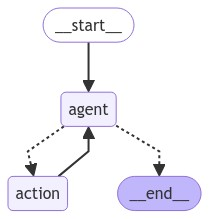

In [5]:
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm Tam")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


input_message = HumanMessage(content="what's my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm Tam


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Hi Tam! How can I assist you today?
================================ Human Message =================================

what's my name?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Your name is Tam! How can I help you today?


## Filtering messages

The most straight-forward thing to do to prevent conversation history from blowing up is to filter the list of messages before they get passed to the LLM. This involves two parts: defining a function to filter messages, and then adding it to the graph. See the example below which defines a really simple `filter_messages` function and then uses it.

In [7]:
from typing import Literal

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import ToolNode

memory = SqliteSaver.from_conn_string(":memory:")


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)
model = ChatOpenAI(model_name="gpt-4o-mini")
bound_model = model.bind_tools(tools)


def should_continue(state: MessagesState) -> Literal["action", "__end__"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise if there is, we continue
    return "action"


def filter_messages(messages: list):
    # This is very simple helper function which only ever uses the last two messages
    return messages[-1:]


# Define the function that calls the model
def call_model(state: MessagesState):
    messages = filter_messages(state["messages"])
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": response}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

In [8]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm Tam")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

# This will now not remember the previous messages
# (because we set `messages[-1:]` in the filter messages argument)
input_message = HumanMessage(content="what's my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm Tam


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Hi Tam! How can I assist you today?
================================ Human Message =================================

what's my name?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

I'm sorry, but I don't know your name. How can I assist you today?


In the above example we defined the `filter_messages` function ourselves. We also provide off-the-shelf ways to trim and filter messages in LangChain. 

- [How to filter messages](https://python.langchain.com/v0.2/docs/how_to/filter_messages/)
- [How to trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/)